In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.hub import load_state_dict_from_url

from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
from torchsummary import summary

#Architecture

##Creating the FCN architecture
The proposed architecture has been composed by simplifying the Resnet architecture and converting it into a Fully Convolutional Network. This choice has been guided by the intention of comparing our model trained from scratch with a resnet network pretrained on the ImageNet dataset. The filter dimensions and strides have been chosen to output a single value (or a 1x1 map) if the input image is a patch and a nxm map for larger images (with n and m depending on the original dimensions of the image. The (i,j)-th element of the map represents the probability that the corresponding area of the photo contains an anomaly (sickness)

In [ ]:
# Define the BasicBlock
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # First convolutional layer with BatchNorm and ReLU
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer with BatchNorm (no ReLU after this layer)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (skip connection)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.downsample(x)
        out = self.relu(out)

        return out

# Define the ResNet-18 architecture
class FCNBinaryClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(FCNBinaryClassifier, self).__init__()

        # Initial convolutional layer and max-pooling
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers (layer1, layer2, layer3, layer4)
        self.layer1 = self.make_layer(BasicBlock, 64, 64, 2, stride=1)
        self.layer2 = self.make_layer(BasicBlock, 64, 128, 2, stride=2)
        self.layer3 = self.make_layer(BasicBlock, 128, 256, 2, stride=2)
        self.layer4 = self.make_layer(BasicBlock, 256, 512, 2, stride=2)

        self.last_conv = nn.Conv2d(in_channels = 512, out_channels = num_classes, kernel_size=1)

        self.avgpool = nn.AvgPool2d(2,2)
        self.sigmoid = nn.Sigmoid()

    def make_layer(self, block, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.last_conv(x)

        x = self.avgpool(x)
        x = self.sigmoid(x)

        return x

# Create an instance of the ResNet-18 model
model = FCNBinaryClassifier(num_classes=1)

# Print the model architecture
print(model)


FCNBinaryClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

#Data processing

##Dataset

This class will be used by the DataLoader class to process the images correctly when loading them. It associates a label (0 for healty, 1 for sick) to each patch. It also transforms the image according to transformation chosen through the optional parameter "transform"

In [ ]:
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

from typing import Callable, Optional, Union, Sequence

def condition(x):
    if "sick" in x:
        return int(1)
    return int(0)

class CanopiesDataset(Dataset):
    def __init__(
        self,
        image_names: Sequence[str],
        transform: Optional[Callable[[torch.Tensor], torch.Tensor]]=None,
    ) -> None:
        """
        `image_names`: sequence of paths to images.
        `transform`: callable to transform the images.
        """
        self.image_names = image_names
        self.transform = transform

    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.
        """
        return len(self.image_names)

    def __getitem__(
        self,
        idx: int,
    ) -> Union[tuple[np.ndarray, int], tuple[torch.Tensor, int]]:
        """
        Returns a tuple of the image and the image itself.

        `idx`: index of the image.
        """
        image = np.array(Image.open(self.image_names[idx]).convert("RGB"))

        if self.transform:
            image = self.transform(image)

        # Extract label from the image path in the form XXXXXXX?label.jpg
        #labels = np.array(os.path.basename(self.image_names[idx]).split("?")[1])
        label = condition(self.image_names[idx])
        return image, label

The next function is necessary to calculate the mean and the standard deviation of the training set. After having obtained them we will use these values to normalize the dataset.

In [ ]:
def calculate_mean_std(image_paths):

    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((64, 64), antialias=True),
        ]
    )

    dataset = CanopiesDataset(
        image_names=image_paths,
        transform=transform,
    )

    loader = DataLoader(
        dataset,
        batch_size=1,
        num_workers=2,
        shuffle=True,
    )

    channel_sum = torch.zeros(3).to("cuda")
    channel_squared_sum = torch.zeros(3).to("cuda")
    i=0
    # Iterate through the dataset to compute sums
    for images, _ in loader:
        i+=1
        images=images.to("cuda")
        channel_sum += torch.mean(images, dim=(0, 2, 3))
        channel_squared_sum += torch.mean(images ** 2, dim=(0, 2, 3))
        images=images.cpu()

    channel_sum=channel_sum.to("cpu")
    channel_squared_sum=channel_squared_sum.to("cpu")
    # Calculate the mean and standard deviation
    mean = channel_sum / len(loader)
    std = torch.sqrt(channel_squared_sum / len(loader) - mean ** 2)
    print("mean = ", mean, "std =", std)
    return mean, std


##Loaders

In this function a funcionality was added to make the training and testing more accurate and not distorted. In fact since so many patches are estracted from 142 full images, many patches insist on the same details (especially the sick patches). This leads to almost identical patches being present in both the training and validation or test set. Therefore the model would be evaluated on patches it's already seen during training, giving and inflated accuracy that doesn't correspond to reality.

###Solution
To mitigate this problem this function takes (among others) a boolean parameter called SMARTER_SPLIT. If true, this parameter forces the split to be made in a more sophisticated way: the patches contain in their names the code of the orginal full resolution image of the grape it was taken from. This codes are grouped up from both the sick and healty folders, shuffled togheter and split into training, validation and testing. The patches are subsequently divided into this three sets according to where their corresponding full image was placed. This way is as if the split has been made on the full bunch of grapes and the model will be evaluated on bunches (and therefore singular grapes) it's never seen before.

###Note:
The function of the boolean parameter called backgroun will be explained in the section titled "The background problem"

In [ ]:
from torch.utils.data import DataLoader

import os
import random


def get_loaders(
    data_dir: str,
    batch_size: int,
    train_percentage: float = 0.8,
    val_percentage: float = 0.1,
    train_limit: Optional[int] = None,
    num_workers: int = 2,
    random_seed: int = 42,
    SMARTER_SPLIT: bool = False,
    BACKGROUND: bool = False
) -> tuple[DataLoader, DataLoader, DataLoader]:

    good_dir = os.path.join(data_dir, "good-patches")
    good_dir_full = os.path.join(data_dir, "goodness")
    good_dir_1 = os.path.join(good_dir, "scale_1")
    good_dir_1_5 = os.path.join(good_dir, "scale_1.5")
    good_dir_2 = os.path.join(good_dir, "scale_2")

    bad_dir = os.path.join(data_dir, "sick-patches")
    bad_dir_full = os.path.join(data_dir, "sickness")
    bad_dir_1 = os.path.join(bad_dir, "scale_1")
    bad_dir_1_5 = os.path.join(bad_dir, "scale_1.5")
    bad_dir_2 = os.path.join(bad_dir, "scale_2")

    full_good_images = (
                        [os.path.join(good_dir_full, image_name)
                        for image_name in os.listdir(good_dir_full)
                        if image_name.endswith(".jpg")]
                      )

    full_bad_images = (
                        [os.path.join(bad_dir_full, image_name)
                        for image_name in os.listdir(bad_dir_full)
                        if image_name.endswith(".jpg")]
                      )

    full_all_images = full_good_images + full_bad_images

    if random_seed is not None:
        random.seed(random_seed)
        random.shuffle(full_all_images)

    good_images = (
        [
            os.path.join(good_dir_1, image_name)
            for image_name in os.listdir(good_dir_1)
            if image_name.endswith(".jpg")
        ]
        + [
            os.path.join(good_dir_1_5, image_name)
            for image_name in os.listdir(good_dir_1_5)
            if image_name.endswith(".jpg")
        ]
        + [
            os.path.join(good_dir_2, image_name)
            for image_name in os.listdir(good_dir_2)
            if image_name.endswith(".jpg")
        ]
    )

    if BACKGROUND:
        back_dir = os.path.join(data_dir, "background_patches/patches")
        background_images = (
            [
                os.path.join(back_dir, image_name)
                for image_name in os.listdir(back_dir)
                if image_name.endswith(".jpg")
            ]
        )

    bad_images = (
        [
            os.path.join(bad_dir_1, image_name)
            for image_name in os.listdir(bad_dir_1)
            if image_name.endswith(".jpg")
        ]
        + [
            os.path.join(bad_dir_1_5, image_name)
            for image_name in os.listdir(bad_dir_1_5)
            if image_name.endswith(".jpg")
        ]
        + [
            os.path.join(bad_dir_2, image_name)
            for image_name in os.listdir(bad_dir_2)
            if image_name.endswith(".jpg")
        ]
    )

    all_images = good_images + bad_images
    if BACKGROUND:
        all_images = all_images + background_images

    if random_seed is not None:
        random.seed(random_seed)
        random.shuffle(all_images)

    #This "smarter" split is made so that the patches of the training, validation and test set have been taken from different bunch
    if SMARTER_SPLIT :

        train_full_images = full_all_images[: int(len(full_all_images) * train_percentage)]
        print("TRAIN FULL images:", len(train_full_images))
        train_codes = set([name.split("_")[2].split(".")[0] for name in train_full_images])
        train_images = [name for name in all_images if name.split("_")[3].split(".")[0] in train_codes]

        print("TRAIN images:", len(train_images))

        val_full_images = full_all_images[int(len(full_all_images) * train_percentage) : int(len(full_all_images) * (train_percentage+val_percentage))]
        val_codes = set([name.split("_")[2].split(".")[0] for name in val_full_images])
        print("VAL FULL images:", len(val_codes))
        val_images = [name for name in all_images if name.split("_")[3].split(".")[0] in val_codes]

        print("VAL images:", len(val_images))

        test_full_images = full_all_images[int(len(full_all_images) * (train_percentage+val_percentage)) : ]
        test_codes = set([name.split("_")[2].split(".")[0] for name in test_full_images])
        print("TEST FULL images:", len(test_codes))
        test_images = [name for name in all_images if name.split("_")[3].split(".")[0] in test_codes]
        print("TEST images:", len(test_images))

        # Check for identical strings using a loop to make sure that the test, validation and training set have no intersection
        identical_strings = []

        for item1 in train_codes:
            for item2 in val_codes:
                if item1 == item2:
                    identical_strings.append(item1)

        if identical_strings:
            print("There are identical strings in the lists:", identical_strings)
        else:
            print("There are no identical strings in the lists.")

        identical_strings = []

        for item1 in train_codes:
            for item2 in test_codes:
                if item1 == item2:
                    identical_strings.append(item1)

        if identical_strings:
            print("There are identical strings in the lists:", identical_strings)
        else:
            print("There are no identical strings in the lists.")


        identical_strings = []

        for item1 in val_codes:
            for item2 in test_codes:
                if item1 == item2:
                    identical_strings.append(item1)

        if identical_strings:
            print("There are identical strings in the lists:", identical_strings)
        else:
            print("There are no identical strings in the lists.")


    #This default split is done randomly and it only assures that no patch is present in two sets at the same time
    else:
        train_images = all_images[: int(len(all_images) * train_percentage)]
        if train_limit is not None:
            train_images = train_images[: train_limit]

        val_images = all_images[
            int(len(all_images) * train_percentage) : int(
                len(all_images) * (train_percentage + val_percentage)
            )
        ]

        test_images = all_images[
            int(len(all_images) * (train_percentage + val_percentage)) :
        ]

    #The mean and std are calculated only on the training set but are used to normalize all the samples
    mean, std = calculate_mean_std(train_images)

    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((64, 64), antialias=True),
            torchvision.transforms.RandomHorizontalFlip(0.5),
            torchvision.transforms.Normalize(mean=mean, std=std),
        ]
    )

    train_dataset = CanopiesDataset(
        image_names=train_images,
        transform=transform,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
    )

    validation_dataset = CanopiesDataset(
        image_names=val_images,
        transform=transform,
    )

    val_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
    )

    test_dataset = CanopiesDataset(
        image_names=test_images,
        transform=transform,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
    )

    return train_loader, val_loader, test_loader



#Training


##Basic functions

In [ ]:
def training(train_loader, model,criterion, optimizer):
    for batch_idx, (data, target) in enumerate(train_loader):
        data=data.to("cuda")
        target=target.to("cuda")
        optimizer.zero_grad()
        outputs = model(data).to("cuda")
        loss = criterion(outputs.squeeze(), target.type(torch.FloatTensor).to(DEVICE))
        loss.backward()
        optimizer.step()
        #print(f"Batch {batch_idx + 1}/{len(train_loader)}, Train Loss: {loss.item()}")

def testing( loader, model, criterion, optimizer):

    model.eval()
    total_loss = 0.0
    all_preds = torch.Tensor().to("cuda")
    all_targets = torch.Tensor().to("cuda")

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device="cuda")
            targets = targets.type(torch.FloatTensor).to(device=DEVICE)

            predictions = model(data)
            loss = criterion(predictions.squeeze(), targets)
            total_loss += loss.item()
            all_preds = torch.cat((all_preds, predictions), 0)
            all_targets = torch.cat((all_targets, targets), 0)

    return all_preds, all_targets, total_loss / len(loader)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = os.path.join("drive", "MyDrive", "Canopies-data")
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)

torch.manual_seed(42)

Mounted at /content/drive
cuda


In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()

##A more complex function
This function contains the loop that iterates through the entire dataset as many times as the epochs parameter specifies. It also takes advantage of checkpoints by saving the states on a google drive folder and loading them back when needed. At each iteration it tests the model on the validation set and stores the loss to plot it afterwards alongside the train loss.

In [ ]:
def full_training(model, criterion, optimizer, train_loader, validation_loader, epochs, model_path = None):
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []
    epochs_so_far = 0

    if model_path is not None and os.path.exists(model_path):
    # Load the checkpoint dictionary
        checkpoint = torch.load(model_path)

        # Load the saved state dictionaries
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epochs_so_far = checkpoint['epoch']
        train_losses = checkpoint['train_losses'][:epochs]
        val_losses = checkpoint['val_losses'][:epochs]
        best_val_loss = min(val_losses)
        print("Model and optimizer loaded from checkpoint. Epoch {}".format(epochs_so_far))

    for epoch in range(epochs - epochs_so_far):
        training( train_loader, model, criterion, optimizer)
        _, _, train_loss = testing(train_loader, model, criterion, optimizer)
        _,_, val_loss = testing(validation_loader, model, criterion, optimizer)

        print("Train Loss: ", train_loss)
        print("Val Loss: ", val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
                best_val_loss = val_loss
                if model_path is not None:
                    best_path = model_path+"-best"
                    checkpoint = {
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "train_loss": train_loss,
                        "val_losses": val_losses,
                        "train_losses": train_losses,
                        "epoch": epoch+epochs_so_far+1,
                    }
                    torch.save(checkpoint, best_path)

        if(model_path is not None):
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss": train_loss,
                "val_losses": val_losses,
                "train_losses": train_losses,
                "epoch": epoch+epochs_so_far+1,
            }
            torch.save(checkpoint, model_path)


    plt.title(f"Optimizer: {optimizer.__class__.__name__} lr: {optimizer.param_groups[0]['lr']} epochs = {epochs}")
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation loss")
    plt.legend(loc='best')
    plt.show()

    return best_val_loss


In [ ]:

BATCH_SIZE = 32
train_loader, validation_loader, test_loader = get_loaders( DATA_DIR, BATCH_SIZE, SMARTER_SPLIT=True)


TRAIN FULL images: 113
TRAIN images: 4348
VAL FULL images: 14
VAL images: 582
TEST FULL images: 15
TEST images: 459
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4008, 0.3507, 0.2766]) std = tensor([0.1771, 0.1754, 0.1736])


##Hyperparameter search
In the following section there is a loop that tests SGD and Adam optimizers with different learning rates and plots the learning curve. We will pick one according to the plots.

TRYING  SGD lr= 0.01
Model and optimizer loaded from checkpoint. Epoch 5


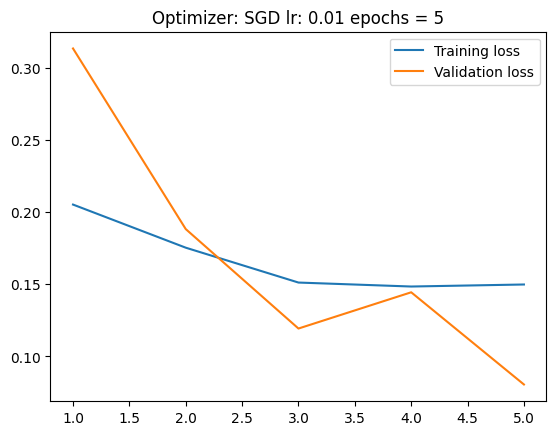

BEST VAL LOSS: 0.08057684867985938
TRYING  SGD lr= 0.001
Model and optimizer loaded from checkpoint. Epoch 5


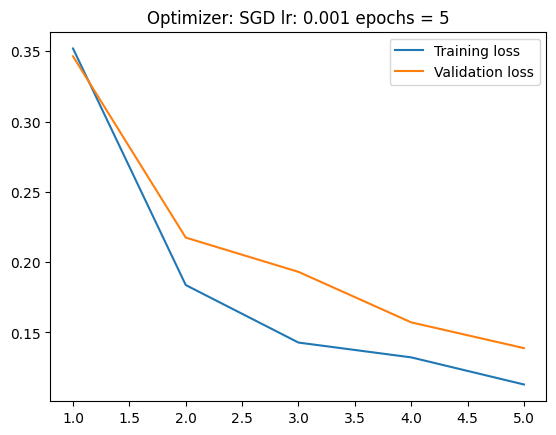

BEST VAL LOSS: 0.13884404850633522
TRYING  SGD lr= 0.0001
Model and optimizer loaded from checkpoint. Epoch 5


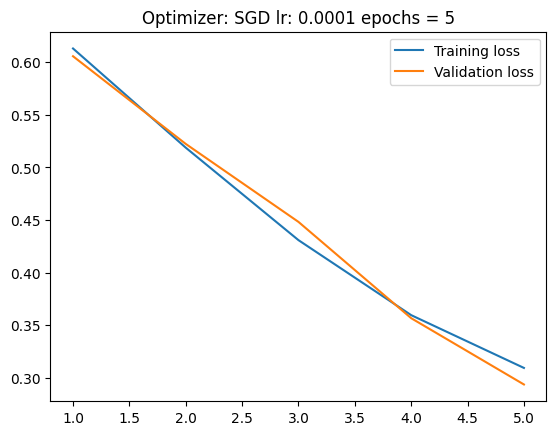

BEST VAL LOSS: 0.29362387406198603
TRYING  SGD lr= 1e-05
Model and optimizer loaded from checkpoint. Epoch 5


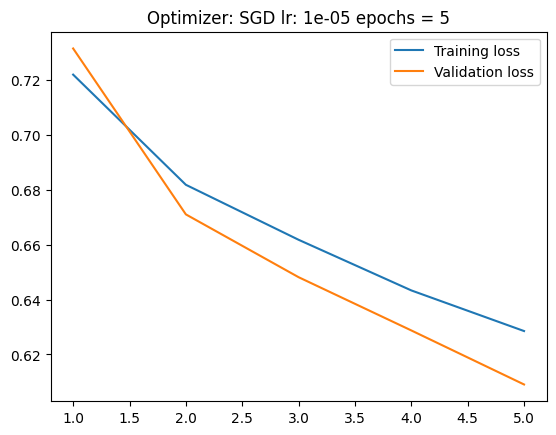

BEST VAL LOSS: 0.609056410036589
TRYING  SGD lr= 1e-06
Model and optimizer loaded from checkpoint. Epoch 5


BEST VAL LOSS: 0.6794081549895438
TRYING  Adam lr= 0.01
Model and optimizer loaded from checkpoint. Epoch 5


BEST VAL LOSS: 0.11541600799874256
TRYING  Adam lr= 0.001
Model and optimizer loaded from checkpoint. Epoch 5


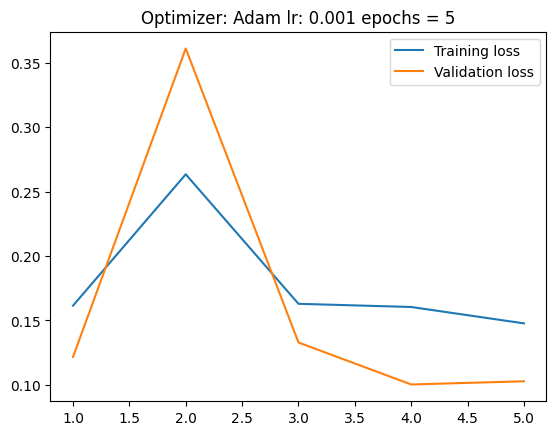

BEST VAL LOSS: 0.1003367400875217
TRYING  Adam lr= 0.0001
Model and optimizer loaded from checkpoint. Epoch 5


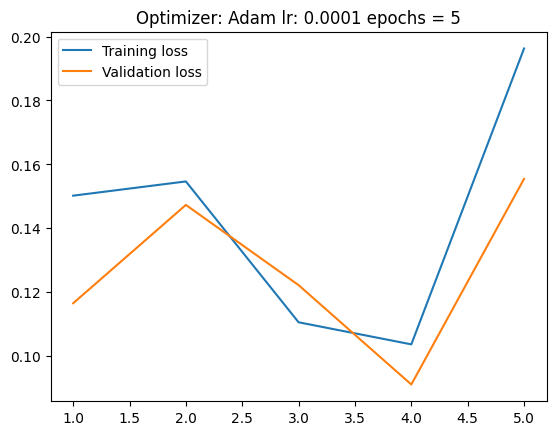

BEST VAL LOSS: 0.091148807226043
TRYING  Adam lr= 1e-05
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.18902355903073362
TRYING  Adam lr= 1e-06
Model and optimizer loaded from checkpoint. Epoch 14


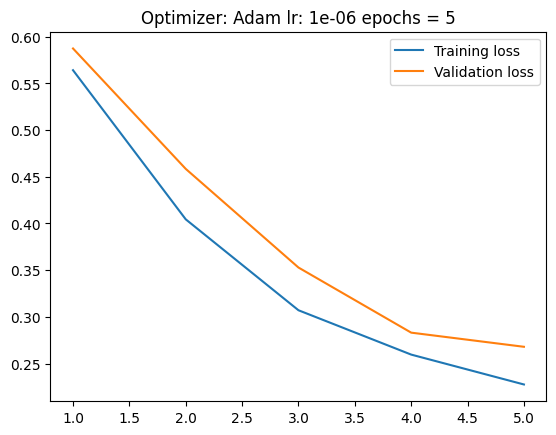

BEST VAL LOSS: 0.26791076754268844


In [ ]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
models_dir = os.path.join("drive", "MyDrive", "models/mia")

for optimizer_class in ["SGD", "Adam"]:
    best_loss = float('inf')

    for lr in learning_rates:
        model = FCNBinaryClassifier(num_classes=1)
        model = model.to(device=DEVICE)
        if(optimizer_class == "SGD"):
            optimizer = optim.SGD(model.parameters(), lr=lr)
        else:
            optimizer = optim.Adam(model.parameters(), lr=lr)

        print("TRYING ", optimizer_class, "lr=",lr)
        bvl = full_training(model, criterion, optimizer, train_loader, validation_loader, 5, os.path.join(models_dir, f"{optimizer_class} lr={lr} bs={BATCH_SIZE} "))
        print("BEST VAL LOSS:", bvl)

        if bvl<best_loss:
            best_loss = bvl
            best_lr = lr



Adam with learning rate 1e-5 and 1e-6 both seem valid choices however, further experiments show that 1e-6 leads to much slower convergence and stalls over 0.2 for the training loss, making 1e-5 a more valid choice.

Next we try to find the best values for the batch size and the number of epochs

TRAIN FULL images: 113
TRAIN images: 4348
VAL FULL images: 14
VAL images: 582
TEST FULL images: 15
TEST images: 459
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4008, 0.3507, 0.2766]) std = tensor([0.1771, 0.1754, 0.1736])
TRYING  Adam  bs= 20  e= 8
Model and optimizer loaded from checkpoint. Epoch 14


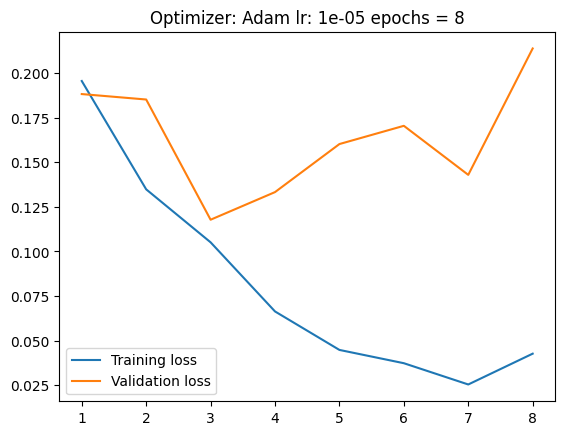

BEST VAL LOSS: 0.1177506715990603
TRYING  Adam  bs= 20  e= 10
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.10654874003181855
TRYING  Adam  bs= 20  e= 12
Model and optimizer loaded from checkpoint. Epoch 14


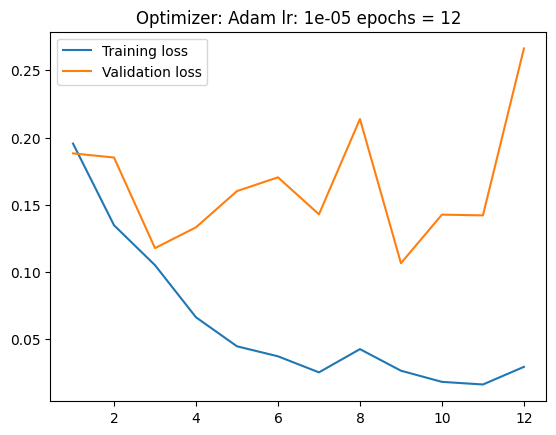

BEST VAL LOSS: 0.10654874003181855
TRYING  Adam  bs= 20  e= 14
Model and optimizer loaded from checkpoint. Epoch 14


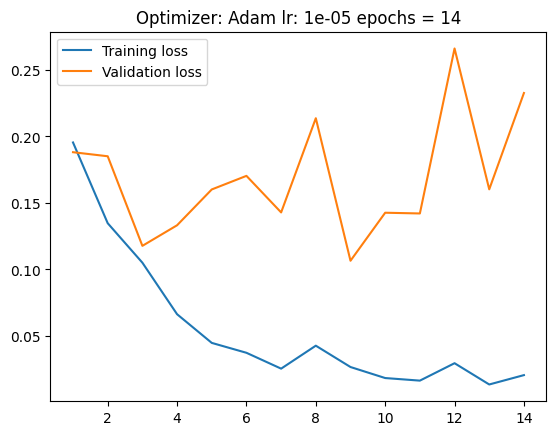

BEST VAL LOSS: 0.10654874003181855
TRAIN FULL images: 113
TRAIN images: 4348
VAL FULL images: 14
VAL images: 582
TEST FULL images: 15
TEST images: 459
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4008, 0.3507, 0.2766]) std = tensor([0.1771, 0.1754, 0.1736])
TRYING  Adam  bs= 32  e= 8
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.18902355903073362
TRYING  Adam  bs= 32  e= 10
Model and optimizer loaded from checkpoint. Epoch 14


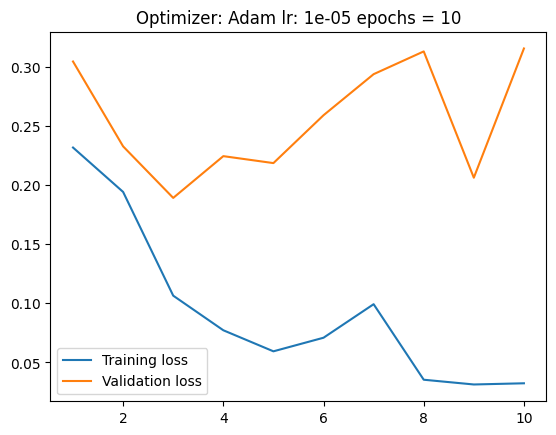

BEST VAL LOSS: 0.18902355903073362
TRYING  Adam  bs= 32  e= 12
Model and optimizer loaded from checkpoint. Epoch 14


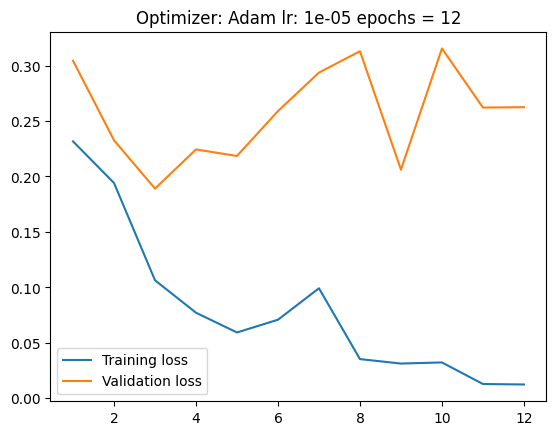

BEST VAL LOSS: 0.18902355903073362
TRYING  Adam  bs= 32  e= 14
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.17794855625221603
TRAIN FULL images: 113
TRAIN images: 4348
VAL FULL images: 14
VAL images: 582
TEST FULL images: 15
TEST images: 459
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4008, 0.3507, 0.2766]) std = tensor([0.1771, 0.1754, 0.1736])
TRYING  Adam  bs= 64  e= 8
Model and optimizer loaded from checkpoint. Epoch 14


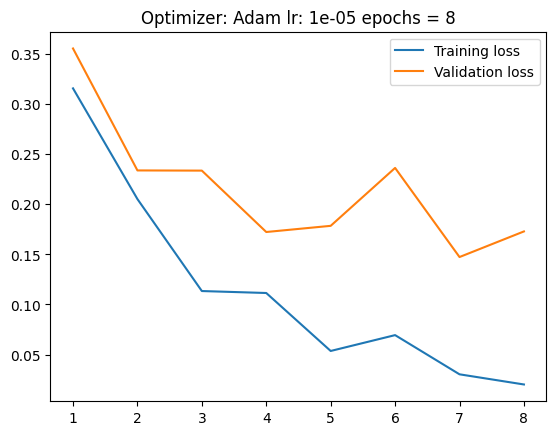

BEST VAL LOSS: 0.14732662923634052
TRYING  Adam  bs= 64  e= 10
Model and optimizer loaded from checkpoint. Epoch 14


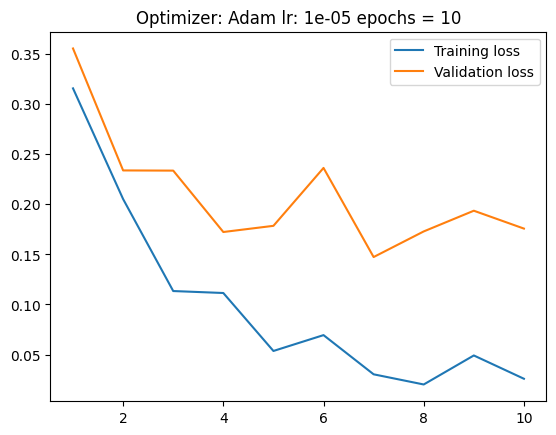

BEST VAL LOSS: 0.14732662923634052
TRYING  Adam  bs= 64  e= 12
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.14401456750929356
TRYING  Adam  bs= 64  e= 14
Model and optimizer loaded from checkpoint. Epoch 14


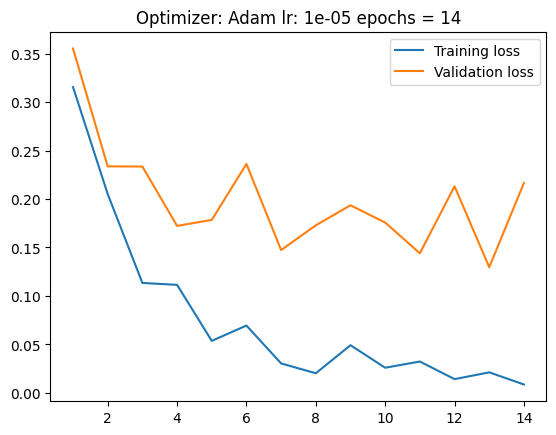

BEST VAL LOSS: 0.12963394932448863
TRAIN FULL images: 113
TRAIN images: 4348
VAL FULL images: 14
VAL images: 582
TEST FULL images: 15
TEST images: 459
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4008, 0.3507, 0.2766]) std = tensor([0.1771, 0.1754, 0.1736])
TRYING  Adam  bs= 128  e= 8
Model and optimizer loaded from checkpoint. Epoch 14


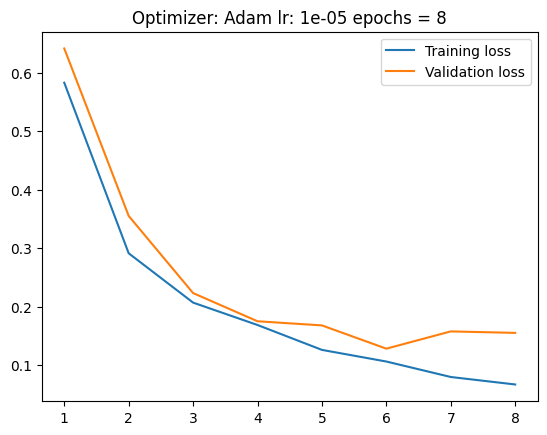

BEST VAL LOSS: 0.12803733348846436
TRYING  Adam  bs= 128  e= 10
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.12803733348846436
TRYING  Adam  bs= 128  e= 12
Model and optimizer loaded from checkpoint. Epoch 14


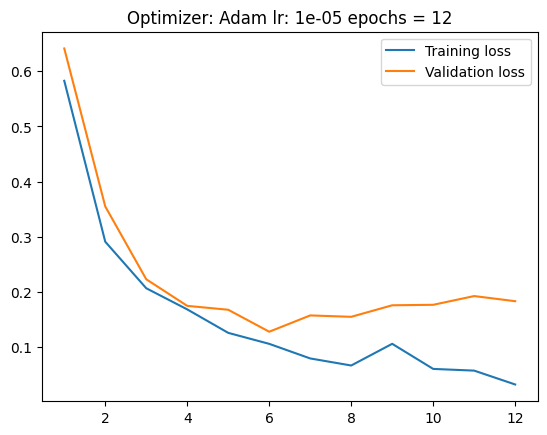

BEST VAL LOSS: 0.12803733348846436
TRYING  Adam  bs= 128  e= 14
Model and optimizer loaded from checkpoint. Epoch 14


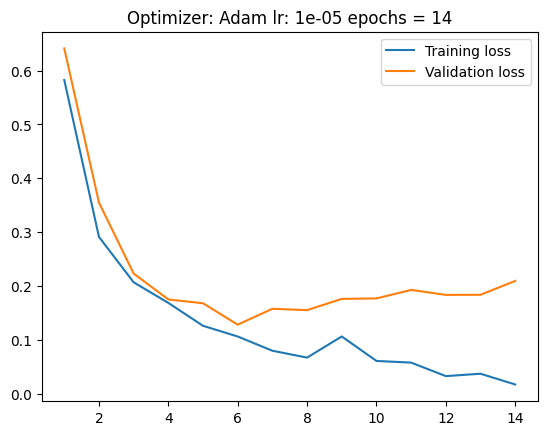

BEST VAL LOSS: 0.12803733348846436
Best validation loss:  0.10654874003181855  obtained with :  Adam  lr =  1e-05  and batch size =  20


In [ ]:
batch_sizes = [20, 32, 64, 128]
epochs = [ 8, 10, 12, 14]

best_loss = float('inf')
for bs in batch_sizes:
    train_loader, validation_loader, test_loader = get_loaders(DATA_DIR, bs, SMARTER_SPLIT=True)
    for e in epochs:
        model = FCNBinaryClassifier(num_classes=1)
        model = model.to(device=DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=1e-5)

        print("TRYING ", optimizer.__class__.__name__, " bs=",bs, " e=", e)
        bvl = full_training(model, criterion, optimizer, train_loader, validation_loader, e, os.path.join(models_dir, f"{optimizer.__class__.__name__} lr={1e-5} bs={bs} "))
        print("BEST VAL LOSS:", bvl)

        if bvl<best_loss:
            best_loss = bvl
            best_bs = bs

print("Best validation loss: ", best_loss, " obtained with : ", optimizer.__class__.__name__, " lr = ", 1e-5, " and batch size = ", best_bs)

TRAIN FULL images: 113
TRAIN images: 4348
VAL FULL images: 14
VAL images: 582
TEST FULL images: 15
TEST images: 459
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4008, 0.3507, 0.2766]) std = tensor([0.1771, 0.1754, 0.1736])
TRYING  Adam  bs= 20  e= 8
Model and optimizer loaded from checkpoint. Epoch 14


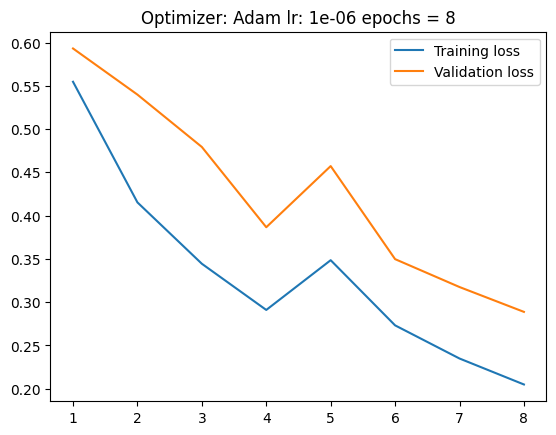

BEST VAL LOSS: 0.28874780734380084
TRYING  Adam  bs= 20  e= 10
Model and optimizer loaded from checkpoint. Epoch 14


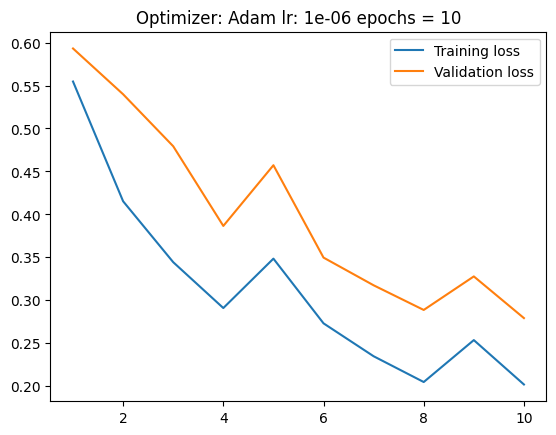

BEST VAL LOSS: 0.2792711819211642
TRYING  Adam  bs= 20  e= 12
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.25809169908364615
TRYING  Adam  bs= 20  e= 14
Model and optimizer loaded from checkpoint. Epoch 14


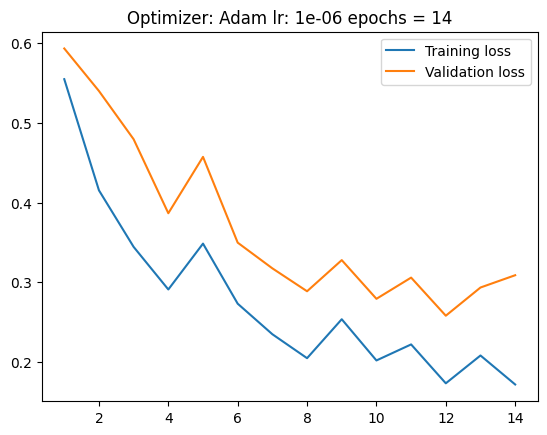

BEST VAL LOSS: 0.25809169908364615
TRAIN FULL images: 113
TRAIN images: 4348
VAL FULL images: 14
VAL images: 582
TEST FULL images: 15
TEST images: 459
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4008, 0.3507, 0.2766]) std = tensor([0.1771, 0.1754, 0.1736])
TRYING  Adam  bs= 32  e= 8
Model and optimizer loaded from checkpoint. Epoch 14


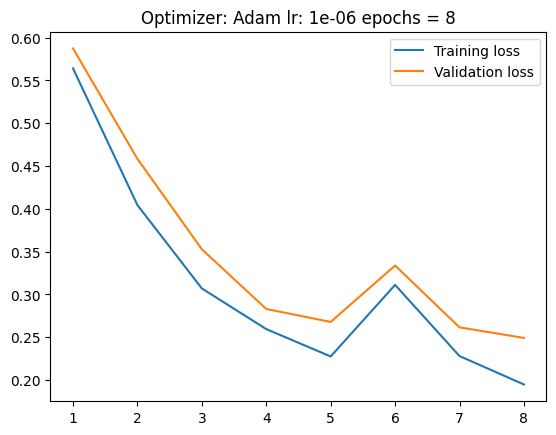

BEST VAL LOSS: 0.2492166922280663
TRYING  Adam  bs= 32  e= 10
Model and optimizer loaded from checkpoint. Epoch 14


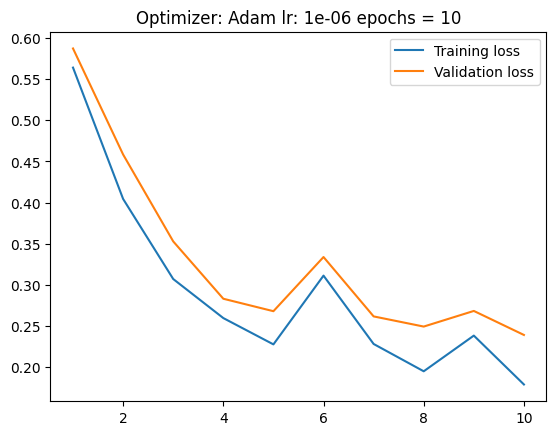

BEST VAL LOSS: 0.23901994918522082
TRYING  Adam  bs= 32  e= 12
Model and optimizer loaded from checkpoint. Epoch 14


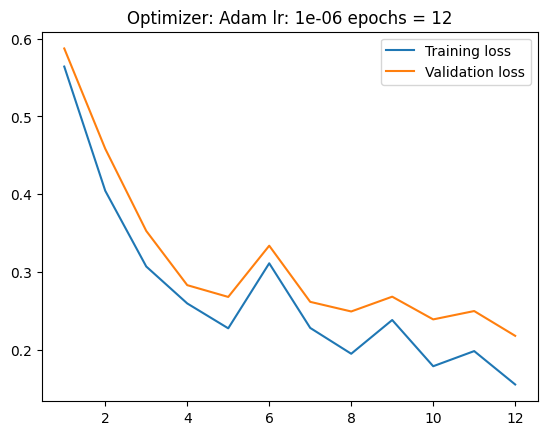

BEST VAL LOSS: 0.2179005663645895
TRYING  Adam  bs= 32  e= 14
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.20691235441910594
TRAIN FULL images: 113
TRAIN images: 4348
VAL FULL images: 14
VAL images: 582
TEST FULL images: 15
TEST images: 459
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4008, 0.3507, 0.2766]) std = tensor([0.1771, 0.1754, 0.1736])
TRYING  Adam  bs= 64  e= 8
Model and optimizer loaded from checkpoint. Epoch 14


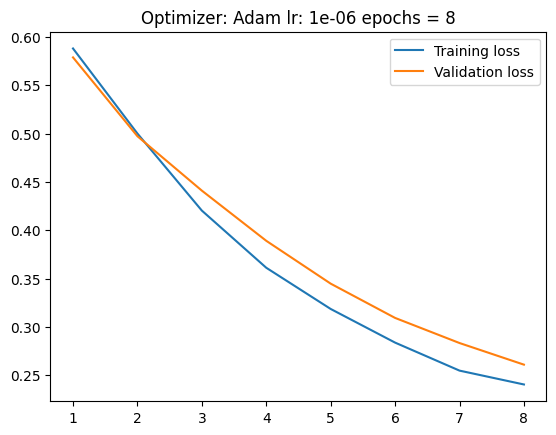

BEST VAL LOSS: 0.26085912585258486
TRYING  Adam  bs= 64  e= 10
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.26085912585258486
TRYING  Adam  bs= 64  e= 12
Model and optimizer loaded from checkpoint. Epoch 14


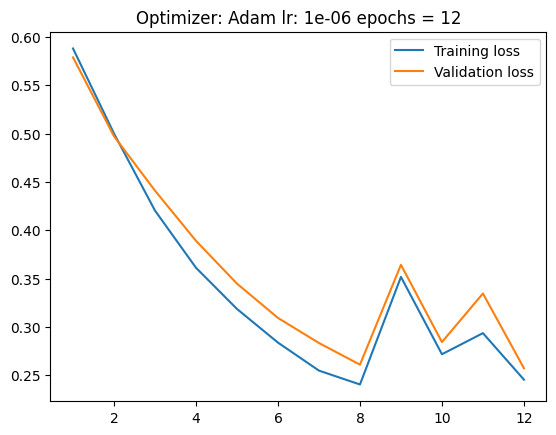

BEST VAL LOSS: 0.25719731003046037
TRYING  Adam  bs= 64  e= 14
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.23827564120292663
TRAIN FULL images: 113
TRAIN images: 4348
VAL FULL images: 14
VAL images: 582
TEST FULL images: 15
TEST images: 459
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4008, 0.3507, 0.2766]) std = tensor([0.1771, 0.1754, 0.1736])
TRYING  Adam  bs= 128  e= 8
Model and optimizer loaded from checkpoint. Epoch 20


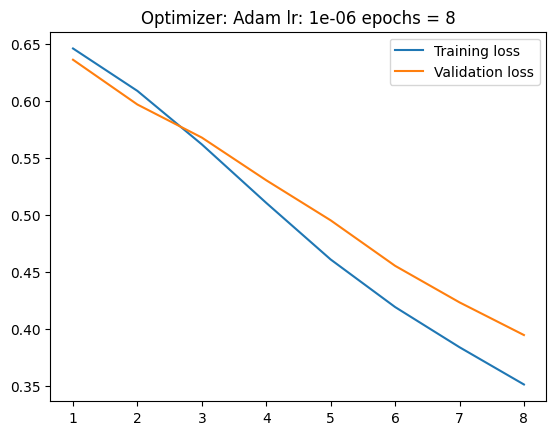

BEST VAL LOSS: 0.3948050320148468
TRYING  Adam  bs= 128  e= 10
Model and optimizer loaded from checkpoint. Epoch 20


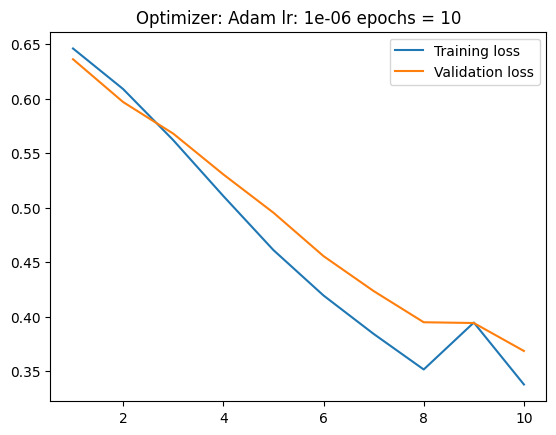

BEST VAL LOSS: 0.3684301793575287
TRYING  Adam  bs= 128  e= 12
Model and optimizer loaded from checkpoint. Epoch 20


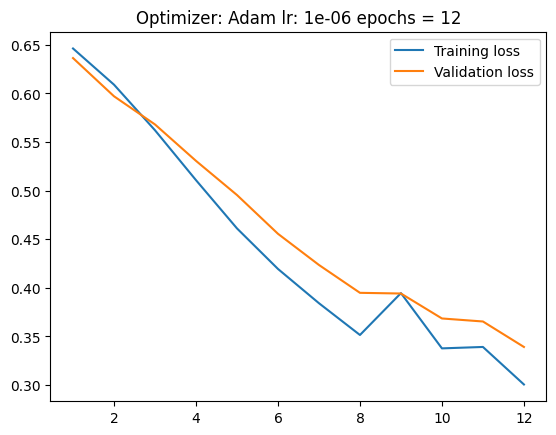

BEST VAL LOSS: 0.33912028670310973
TRYING  Adam  bs= 128  e= 14
Model and optimizer loaded from checkpoint. Epoch 20


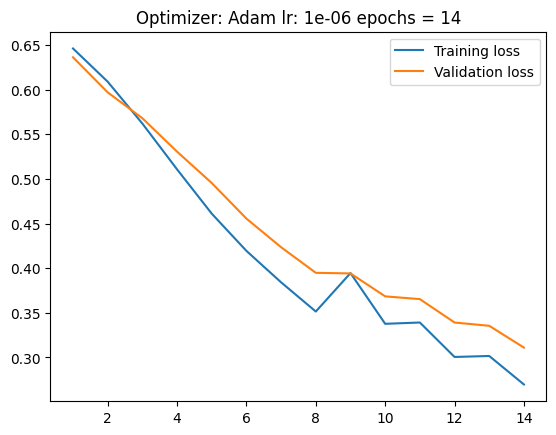

BEST VAL LOSS: 0.311019766330719
Best validation loss:  0.20691235441910594  obtained with :  Adam  lr =  1e-06  and batch size =  32


In [ ]:
batch_sizes = [20, 32, 64, 128]
epochs = [ 8, 10, 12, 14]

best_loss = float('inf')
for bs in batch_sizes:
    train_loader, validation_loader, test_loader = get_loaders(DATA_DIR, bs, SMARTER_SPLIT=True)
    for e in epochs:
        model = FCNBinaryClassifier(num_classes=1)
        model = model.to(device=DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=1e-6)

        print("TRYING ", optimizer.__class__.__name__, " bs=",bs, " e=", e)
        bvl = full_training(model, criterion, optimizer, train_loader, validation_loader, e, os.path.join(models_dir, f"{optimizer.__class__.__name__} lr={1e-6} bs={bs} "))
        print("BEST VAL LOSS:", bvl)

        if bvl<best_loss:
            best_loss = bvl
            best_bs = bs

print("Best validation loss: ", best_loss, " obtained with : ", optimizer.__class__.__name__, " lr = ", 1e-6, " and batch size = ", best_bs)

#Test Evaluation
Now that we have trained our model, we need to test it's performance on the test set. Moreover we can calculate other metrics like precision etc

In [ ]:
model = FCNBinaryClassifier(num_classes=1)
model = model.to(DEVICE)

models_dir = os.path.join("drive", "MyDrive", "models/mia")
checkpoint = torch.load(os.path.join(models_dir, f"Adam lr={1e-5} bs={128} -best"))

# Load the saved state dictionaries
model.load_state_dict(checkpoint['model_state_dict'])
epochs_so_far = checkpoint['epoch']

print("Model loaded from checkpoint. Epoch {}".format(epochs_so_far))

predictions, targets, loss = testing(test_loader, model, criterion, optimizer)


Model loaded from checkpoint. Epoch 6


In [ ]:

class_predictions = (predictions.squeeze() > 0.5).int()
print(class_predictions)
print(targets)


tensor([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,

[10, 13, 27, 53, 79, 148, 150, 201, 203, 227, 261, 318, 349, 367, 382, 388, 425, 432, 452, 453]


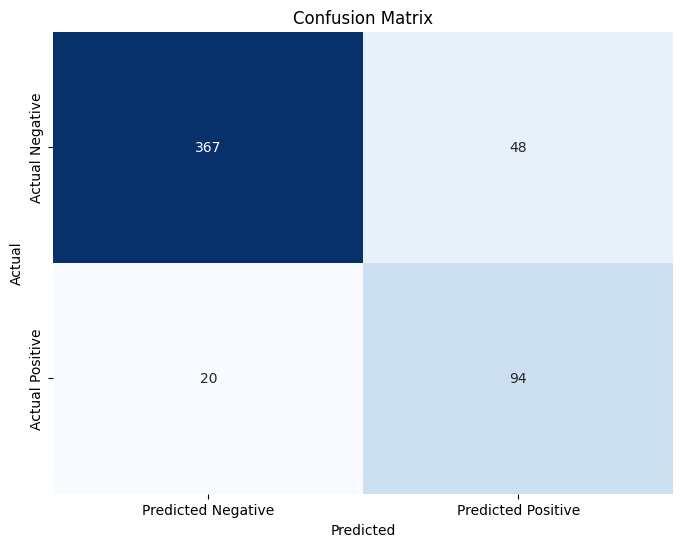

Accuracy:  tensor(0.8715, device='cuda:0')
Precision:  tensor(0.6620, device='cuda:0')
Recall:  tensor(0.8246, device='cuda:0')
Specificity:  tensor(0.8843, device='cuda:0')


In [ ]:
TP = torch.sum((class_predictions== 1) & (targets == 1))
TN = torch.sum((class_predictions == 0) & (targets == 0))
FP = torch.sum((class_predictions == 1) & (targets == 0))
FN = torch.sum((class_predictions == 0) & (targets == 1))
correct_predictions = TP+TN

false_positives = ((class_predictions == 1) & (targets == 0)).nonzero().squeeze()
false_negatives = ((class_predictions == 0) & (targets == 1)).nonzero().squeeze()

# Convert the results to lists of indices
false_positives = false_positives.tolist()
false_negatives = false_negatives.tolist()

print(false_negatives)

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(targets.cpu(), class_predictions.cpu())

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)


#Failure Analysis

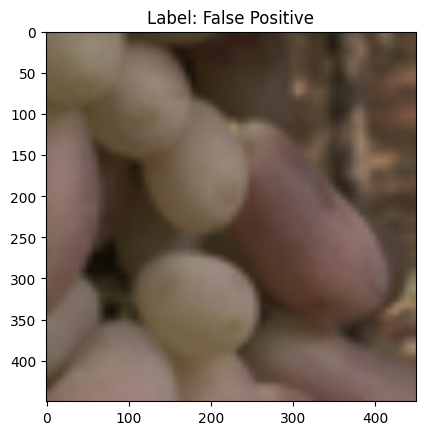

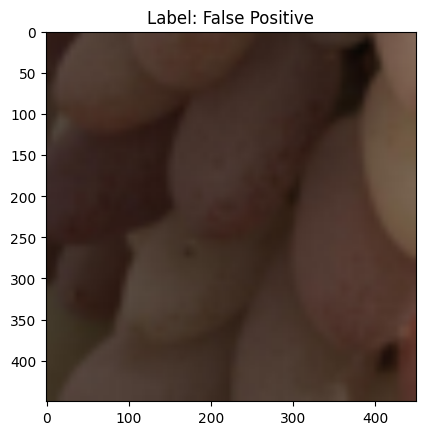

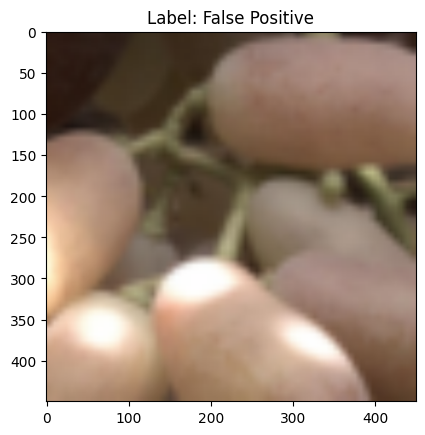

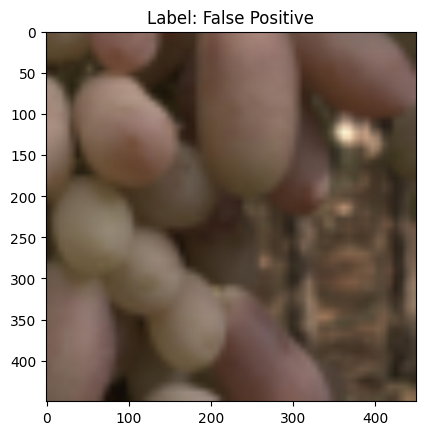

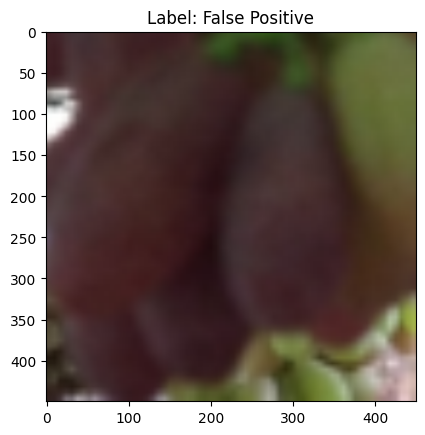

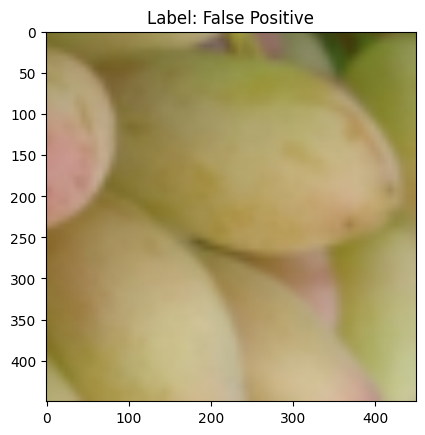

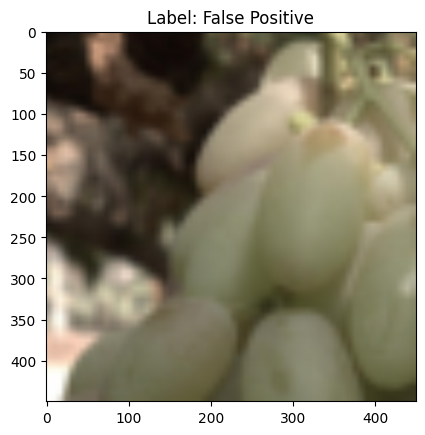

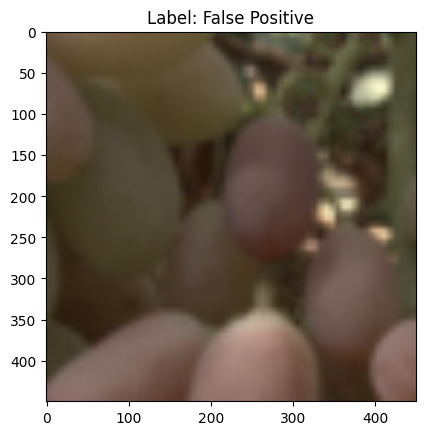

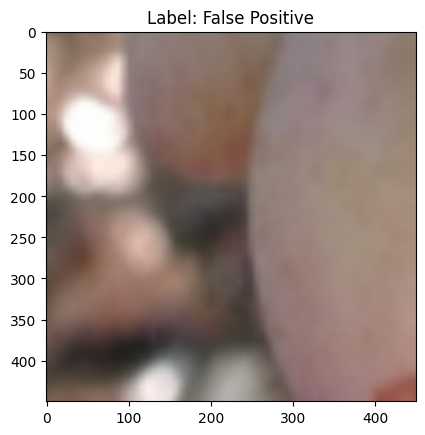

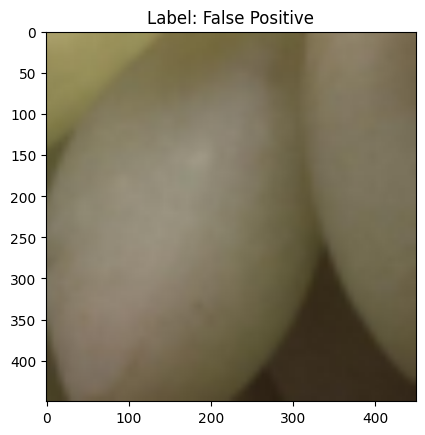

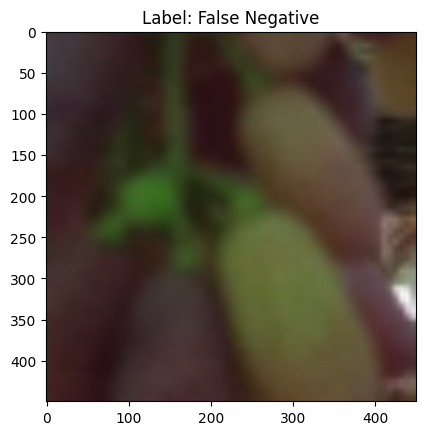

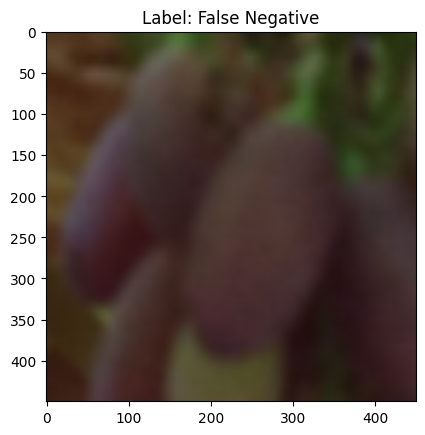

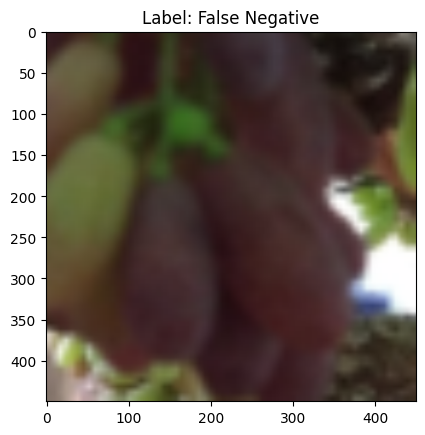

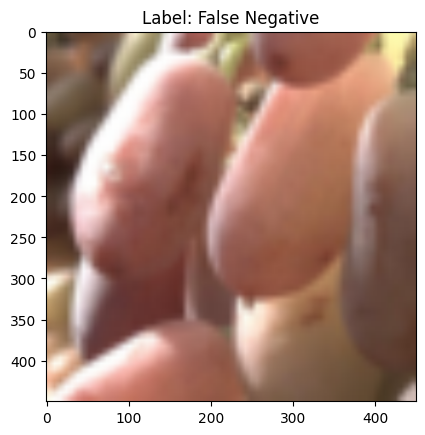

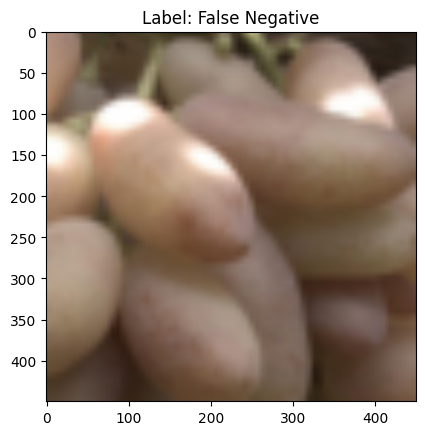

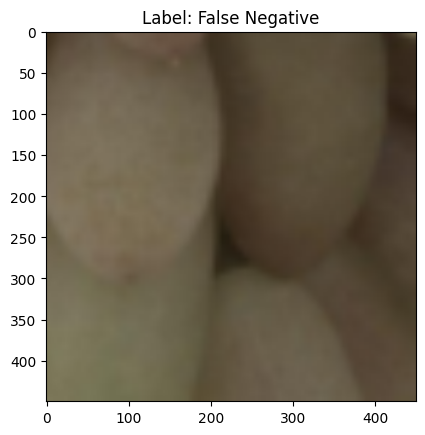

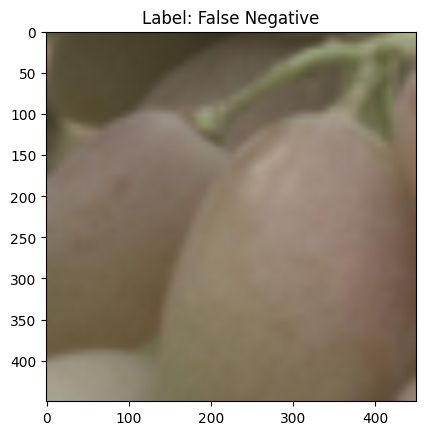

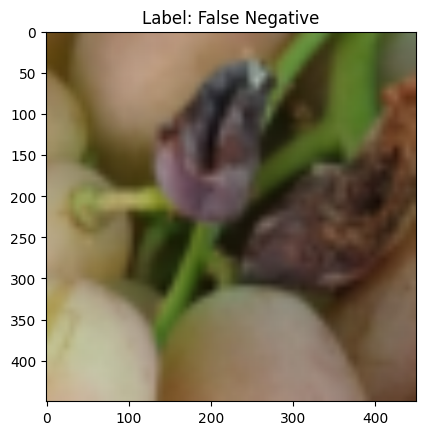

IndexError: ignored

In [ ]:

for j in false_positives[:10]:
    i = 0
    if j>128*i-1:
        i+=1
        batch, labels = next(iter(test_loader))
    desired_image = batch[j-128*i]
    desired_label = labels[j-128*i]
    # Denormalization: Reverse the normalization
    mean = torch.tensor([0.4008, 0.3507, 0.2766])
    std = torch.tensor([0.1771, 0.1754, 0.1736])
    denormalized_image = desired_image * std.view(3,1,1) + mean.view(3,1,1)
    # Convert the denormalized image back to 8-bit integer format (0-255)
    denormalized_image = (denormalized_image * 255).to(torch.uint8)
    # Upsample the denormalized image to the original size
    original_size = (450, 450)
    original_image = Image.fromarray(denormalized_image.permute(1,2,0).numpy())
    original_image = original_image.resize(original_size, Image.BILINEAR)
    plt.imshow(original_image)
    plt.title(f"Label: False Positive")
    plt.show()

for j in false_negatives[:10]:
    i = 0
    if j>128*i-1:
        i+=1
        batch, labels = next(iter(test_loader))
    desired_image = batch[j-128*i]
    desired_label = labels[j-128*i]
    # Denormalization: Reverse the normalization
    mean = torch.tensor([0.4008, 0.3507, 0.2766])
    std = torch.tensor([0.1771, 0.1754, 0.1736])
    denormalized_image = desired_image * std.view(3,1,1) + mean.view(3,1,1)
    # Convert the denormalized image back to 8-bit integer format (0-255)
    denormalized_image = (denormalized_image * 255).to(torch.uint8)
    # Upsample the denormalized image to the original size
    original_size = (450, 450)
    original_image = Image.fromarray(denormalized_image.permute(1,2,0).numpy())
    original_image = original_image.resize(original_size, Image.BILINEAR)
    plt.imshow(original_image)
    plt.title(f"Label: False Negative")
    plt.show()


We can see that often times the model fails and gives a false positive when the patch contains a portion of the background, when the grapes even if healty presents spots of different color on their skin, ore when these is a grape that is darker than the ones adjacent to it.

Similarly, false negatives happen when the sickness is not very apparent, especially when the grapes maintain their overall round appearance and/or bright color.

This will probably give us distorted bounding boxes when applying the model to full images.

#Experimenting with a pretrained model (modified ResNet18)

The following section contains a comparison between our model and a network pretrained on ImageNet (ResNet18), but first we need to modify the last layer of Resnet to make it fully convolutional. Afterwards we will load the pretrained weights.

In [ ]:

class FCNBinaryResNet(nn.Module):
    def __init__(self, num_classes=1, pretrained=False):
        super(FCNBinaryResNet, self).__init__()
        self.pretrained_model = models.resnet18(pretrained=pretrained)
        in_features = self.pretrained_model.fc.in_features
        self.pretrained_model.fc = nn.Linear(in_features, num_classes)
        self.last_conv = nn.Conv2d(in_channels = in_features, out_channels = num_classes, kernel_size=1)
        self.last_conv.weight.data.copy_( self.pretrained_model.fc.weight.data.view ( *self.pretrained_model.fc.weight.data.shape, 1, 1))
        self.last_conv.bias.data.copy_ (self.pretrained_model.fc.bias.data)

        self.avgpool = nn.AvgPool2d(2,2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pretrained_model.conv1(x)
        #print(x.shape)
        x = self.pretrained_model.bn1(x)
        x = self.pretrained_model.relu(x)
        x = self.pretrained_model.maxpool(x)
        #print(x.shape)

        x = self.pretrained_model.layer1(x)
        x = self.pretrained_model.layer2(x)
        x = self.pretrained_model.layer3(x)
        x = self.pretrained_model.layer4(x)
        #print(x.shape)
        x = self.avgpool(x)
        #print(x.shape)

        # Notice, there is no forward pass
        # through the original fully connected layer.
        # Instead, we forward pass through the last conv layer
        x = self.last_conv(x)
        x = self.sigmoid(x)
        #print(x.shape)
        return x



TRAIN FULL images: 113
TRAIN images: 4348
VAL FULL images: 14
VAL images: 582
TEST FULL images: 15
TEST images: 459
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4008, 0.3507, 0.2766]) std = tensor([0.1771, 0.1754, 0.1736])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


TRYING  Adam  bs= 64  e= 14
Model and optimizer loaded from checkpoint. Epoch 8
Train Loss:  0.46278925108558994
Val Loss:  0.5279812932014465
Train Loss:  0.25828175312455964
Val Loss:  0.24964707791805268
Train Loss:  0.18518109619617462
Val Loss:  0.1514148898422718
Train Loss:  0.14722506165066185
Val Loss:  0.11627609506249428
Train Loss:  0.13011962887557113
Val Loss:  0.10020308271050453
Train Loss:  0.11461801147636246
Val Loss:  0.09431003704667092


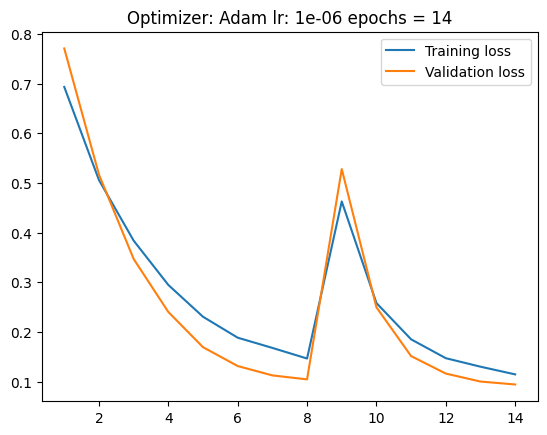

In [ ]:
train_loader, validation_loader, test_loader = get_loaders(DATA_DIR, 64, SMARTER_SPLIT=True)

pretrained_model = FCNBinaryResNet(pretrained=True)
optimizer = optim.Adam(pretrained_model.parameters(), lr=1e-6)

pretrained_models_dir = os.path.join("drive", "MyDrive", "models/resnet-pre")
pretrained_model = pretrained_model.to("cuda")
print("TRYING ", optimizer.__class__.__name__, " bs=",64, " e=", 14)
bvl = full_training(pretrained_model, criterion, optimizer, train_loader, validation_loader, 14, os.path.join(pretrained_models_dir, f"{optimizer.__class__.__name__} lr={1e-6} bs={64} "))

In [ ]:
model = FCNBinaryResNet(pretrained=True)
model = model.to(DEVICE)

checkpoint = torch.load(os.path.join("drive/MyDrive/models/resnet-pre", f"Adam lr={1e-5} bs={128} -best"))

# Load the saved state dictionaries
model.load_state_dict(checkpoint['model_state_dict'])
epochs_so_far = checkpoint['epoch']

print("Model loaded from checkpoint. Epoch {}".format(epochs_so_far))

predictions, targets, loss = testing(test_loader, model, criterion, optimizer)

class_predictions = (predictions.squeeze() > 0.5).int()
print(class_predictions)
print(targets)

correct_predictions = (class_predictions == targets).sum().item()

# Calculate accuracy
accuracy = correct_predictions / len(targets)
print(accuracy)

Model loaded from checkpoint. Epoch 3
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  

As we've seen the pretrained model performs about 4% better than our model. This hints that the dataset we've created and trained the model on is good enough for the task we're trying to achieve. This might also mean that the training has been effective, and also that the task we have is very specific and the features learned from ImageNet are not very useful.

#Full Images application
The classifier we have trained on small patches can be used on larger images as well being a FCN. In that case it will output a map of probabilities. By applying a threshold to those probabilities and using the resulting binary map as an indication of where the anomalies are we can trace borders aroung the sick areas of the grapes.

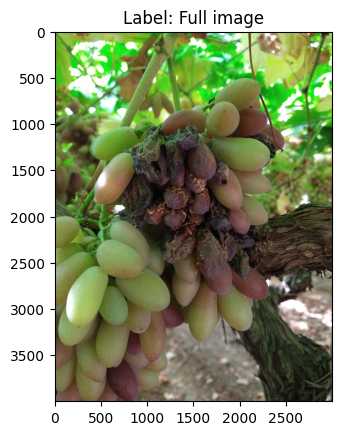

(3000, 4000, 3)
Model loaded from checkpoint. Epoch 6
(9, 7)
[[0 1 0 1 1 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


-1

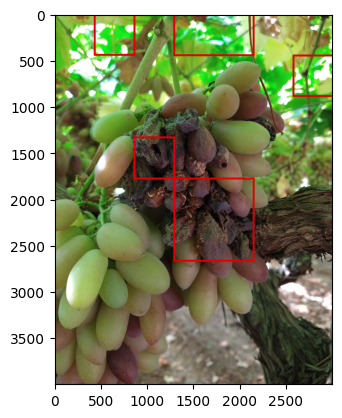

In [ ]:
image_path = os.path.join(DATA_DIR, "sickness/IMG_20210924_131131409.jpg")
original_image = np.array(Image.open(image_path).convert("RGB"))

plt.imshow(original_image.transpose(1,0,2))
plt.title(f"Label: Full image")
plt.show()
print(original_image.shape)
transform1 = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((original_image.shape[0]//7, original_image.shape[1]//7), antialias=True)         ,
            torchvision.transforms.Normalize(mean=[0.4008, 0.3507, 0.2766], std =[0.1771, 0.1754, 0.1736]),
        ]
    )

image = transform1(original_image)

model = FCNBinaryClassifier(num_classes=1)
model = model.to(DEVICE)

checkpoint = torch.load(os.path.join("drive/MyDrive/models/mia", f"Adam lr={1e-5} bs={128} -best"))

# Load the saved state dictionaries
model.load_state_dict(checkpoint['model_state_dict'])
epochs_so_far = checkpoint['epoch']

print("Model loaded from checkpoint. Epoch {}".format(epochs_so_far))

image = torch.unsqueeze(image,0).to(device=DEVICE)
score_map = model(image)
print(score_map)
score_map = (score_map>0.85).int()
score_map = score_map.squeeze().cpu().detach().numpy()

print(score_map.transpose().shape)
print(score_map.transpose())

score_map = np.array(score_map, dtype=np.uint8)

#original_image = cv2.imread(image_path)
plt.imshow(original_image)
#plt.show

# Resize score map to the original image size
score_map = cv2.resize(score_map, (original_image.shape[1], original_image.shape[0]))

# Find the countour of the binary blob
contours, _ = cv2.findContours(score_map, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

# Find bounding box around the object.
for i in range(len(contours)):
  rect = cv2.boundingRect(contours[i])
  cv2.rectangle(original_image, rect[:2], (rect[0] + rect[2], rect[1] + rect[3]), (225,0, 0), 20)


#masked_image = (original_image * score_map).astype(np.uint8)

# Display bounding box
# Display images
plt.imshow(original_image.transpose(1,0,2))
plt.show

cv2.waitKey(0)

##The background problem


As seen in the previous section, this model has a hard time when analizing the background. In the background there are sharp edges and rapid changes of color that the model has learned to be frequent in the sick patches. Therefore it detects anomalies in the background. The proposed method to mitigate the problem is to include patches taken from the background area, label them as not sick and retrain the model. This can be made by passing the True value to get_loaders function through the BACKGROUND parameter. What this does is tell the function to get the patches from an additional background folder and then put them togheter with the other patches. They will be labeld as healty since the string "sick" is not contained in their paths.

The results are shown below

TRAIN FULL images: 113
TRAIN images: 4829
VAL FULL images: 14
VAL images: 654
TEST FULL images: 15
TEST images: 529
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4021, 0.3569, 0.2781]) std = tensor([0.1811, 0.1833, 0.1774])
TRYING  Adam  bs= 20  e= 8
Model and optimizer loaded from checkpoint. Epoch 14


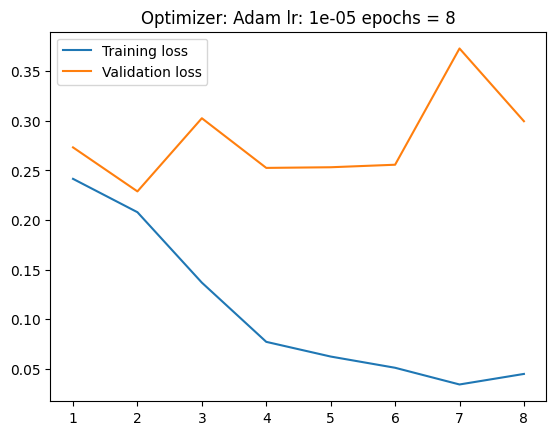

BEST VAL LOSS: 0.22887950034981425
TRYING  Adam  bs= 20  e= 10
Model and optimizer loaded from checkpoint. Epoch 14


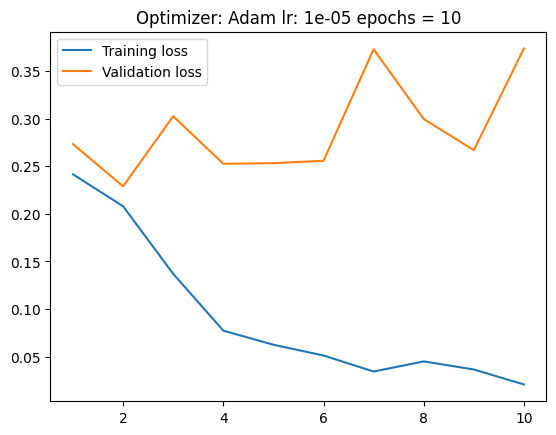

BEST VAL LOSS: 0.22887950034981425
TRYING  Adam  bs= 20  e= 12
Model and optimizer loaded from checkpoint. Epoch 14


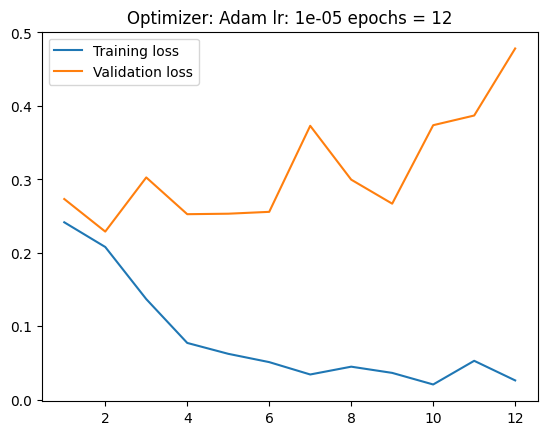

BEST VAL LOSS: 0.22887950034981425
TRYING  Adam  bs= 20  e= 14
Model and optimizer loaded from checkpoint. Epoch 14


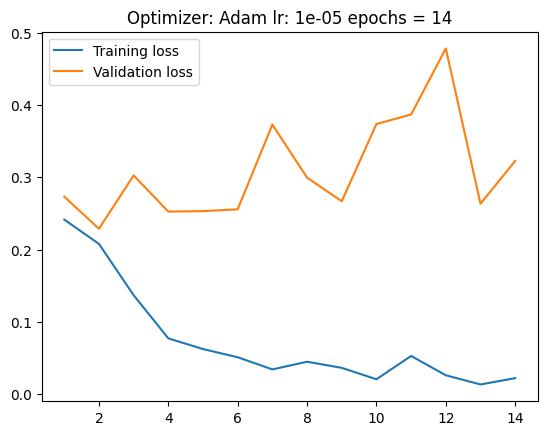

BEST VAL LOSS: 0.22887950034981425
TRAIN FULL images: 113
TRAIN images: 4829
VAL FULL images: 14
VAL images: 654
TEST FULL images: 15
TEST images: 529
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4021, 0.3569, 0.2781]) std = tensor([0.1811, 0.1833, 0.1774])
TRYING  Adam  bs= 32  e= 8
Model and optimizer loaded from checkpoint. Epoch 14


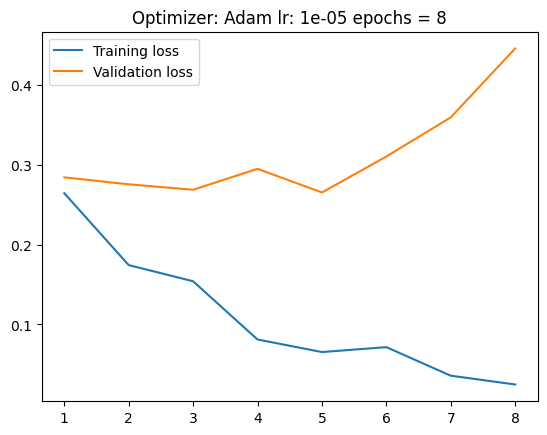

BEST VAL LOSS: 0.2652656740198533
TRYING  Adam  bs= 32  e= 10
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.2617936948580401
TRYING  Adam  bs= 32  e= 12
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.2617936948580401
TRYING  Adam  bs= 32  e= 14
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.25360507722057046
TRAIN FULL images: 113
TRAIN images: 4829
VAL FULL images: 14
VAL images: 654
TEST FULL images: 15
TEST images: 529
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4021, 0.3569, 0.2781]) std = tensor([0.1811, 0.1833, 0.1774])
TRYING  Adam  bs= 64  e= 8
Model and optimizer loaded from checkpoint. Epoch 14


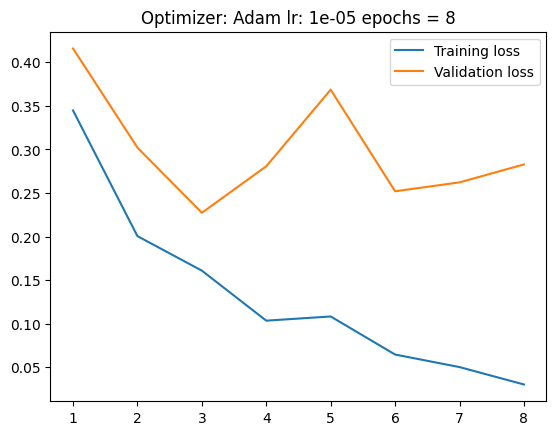

BEST VAL LOSS: 0.22730010443113066
TRYING  Adam  bs= 64  e= 10
Model and optimizer loaded from checkpoint. Epoch 14


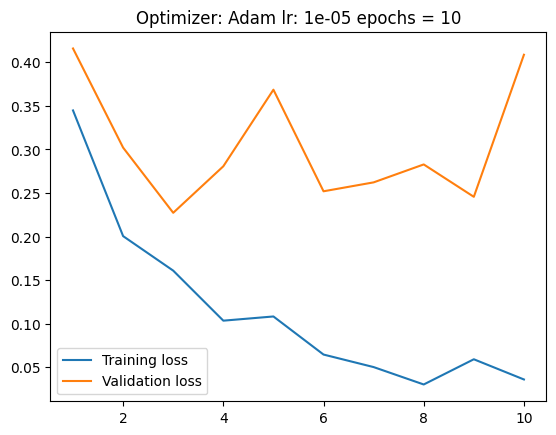

BEST VAL LOSS: 0.22730010443113066
TRYING  Adam  bs= 64  e= 12
Model and optimizer loaded from checkpoint. Epoch 14


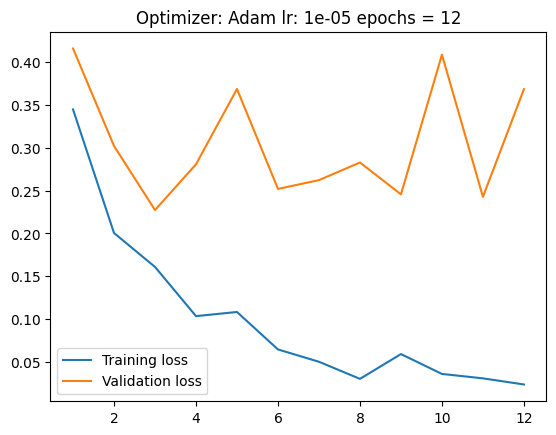

BEST VAL LOSS: 0.22730010443113066
TRYING  Adam  bs= 64  e= 14
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.22730010443113066
TRAIN FULL images: 113
TRAIN images: 4829
VAL FULL images: 14
VAL images: 654
TEST FULL images: 15
TEST images: 529
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4021, 0.3569, 0.2781]) std = tensor([0.1811, 0.1833, 0.1774])
TRYING  Adam  bs= 128  e= 8
Model and optimizer loaded from checkpoint. Epoch 14


BEST VAL LOSS: 0.20929352566599846
TRYING  Adam  bs= 128  e= 10
Model and optimizer loaded from checkpoint. Epoch 14


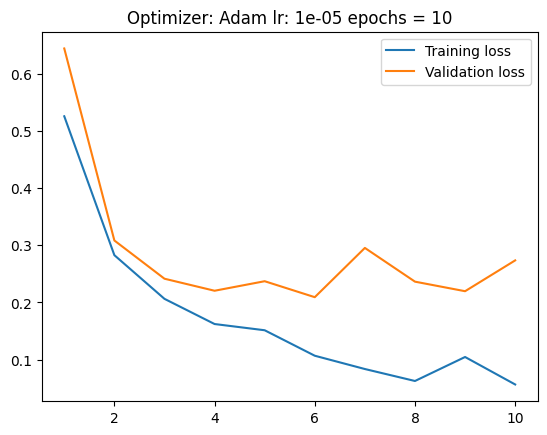

BEST VAL LOSS: 0.20929352566599846
TRYING  Adam  bs= 128  e= 12
Model and optimizer loaded from checkpoint. Epoch 14


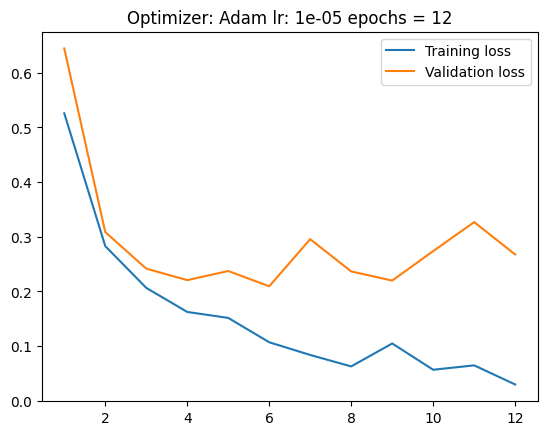

BEST VAL LOSS: 0.20929352566599846
TRYING  Adam  bs= 128  e= 14
Model and optimizer loaded from checkpoint. Epoch 14


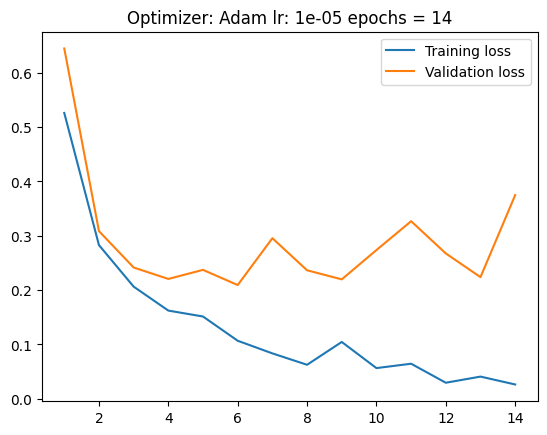

BEST VAL LOSS: 0.20929352566599846
Best validation loss:  0.20929352566599846  obtained with :  Adam  lr =  1e-06  and batch size =  128


In [ ]:
batch_sizes = [20, 32, 64, 128]
epochs = [ 8, 10, 12, 14]
models_dir = os.path.join("drive", "MyDrive", "models/mia/background")

best_loss = float('inf')
for bs in batch_sizes:
    train_loader, validation_loader, test_loader = get_loaders(DATA_DIR, bs, SMARTER_SPLIT=True, BACKGROUND=True)
    for e in epochs:
        model = FCNBinaryClassifier(num_classes=1)
        model = model.to(device=DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=1e-5)

        print("TRYING ", optimizer.__class__.__name__, " bs=",bs, " e=", e)
        bvl = full_training(model, criterion, optimizer, train_loader, validation_loader, e, os.path.join(models_dir, f"{optimizer.__class__.__name__} lr={1e-5} bs={bs} "))
        print("BEST VAL LOSS:", bvl)

        if bvl<best_loss:
            best_loss = bvl
            best_bs = bs

print("Best validation loss: ", best_loss, " obtained with : ", optimizer.__class__.__name__, " lr = ", 1e-6, " and batch size = ", best_bs)

In [ ]:
model = FCNBinaryClassifier(num_classes=1)
model = model.to(DEVICE)

checkpoint = torch.load(os.path.join("drive/MyDrive/models/mia/background", f"Adam lr={1e-5} bs={128} -best"))

# Load the saved state dictionaries
model.load_state_dict(checkpoint['model_state_dict'])
epochs_so_far = checkpoint['epoch']

train_loader, validation_loader, test_loader = get_loaders(DATA_DIR, bs, SMARTER_SPLIT=True, BACKGROUND=True)

print("Model loaded from checkpoint. Epoch {}".format(epochs_so_far))

predictions, targets, loss = testing(test_loader, model, criterion, optimizer)

class_predictions = (predictions.squeeze() > 0.5).int()
print(class_predictions)
print(targets)

TRAIN FULL images: 113
TRAIN images: 4829
VAL FULL images: 14
VAL images: 654
TEST FULL images: 15
TEST images: 529
There are no identical strings in the lists.
There are no identical strings in the lists.
There are no identical strings in the lists.
mean =  tensor([0.4021, 0.3569, 0.2781]) std = tensor([0.1811, 0.1833, 0.1774])
Model loaded from checkpoint. Epoch 6
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 

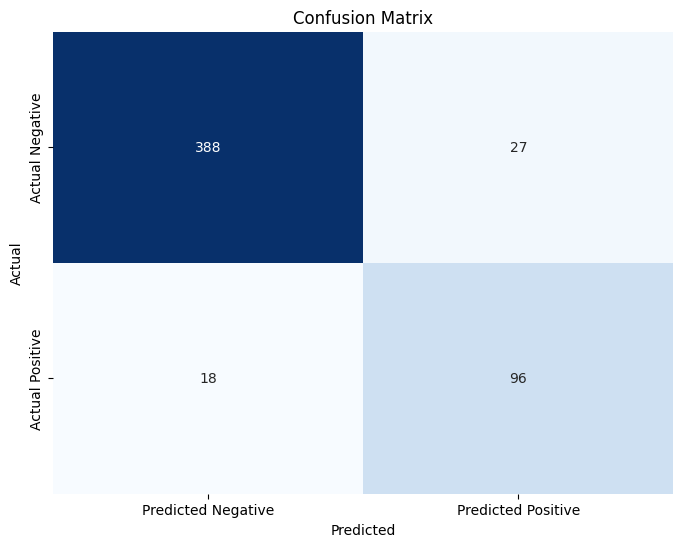

Accuracy:  tensor(0.9149, device='cuda:0')
Precision:  tensor(0.7805, device='cuda:0')
Recall:  tensor(0.8421, device='cuda:0')
Specificity:  tensor(0.9349, device='cuda:0')


In [ ]:
TP = torch.sum((class_predictions== 1) & (targets == 1))
TN = torch.sum((class_predictions == 0) & (targets == 0))
FP = torch.sum((class_predictions == 1) & (targets == 0))
FN = torch.sum((class_predictions == 0) & (targets == 1))
correct_predictions = TP+TN

false_positives = ((class_predictions == 1) & (targets == 0)).nonzero().squeeze()
false_negatives = ((class_predictions == 0) & (targets == 1)).nonzero().squeeze()

# Convert the results to lists of indices
false_positives = false_positives.tolist()
false_negatives = false_negatives.tolist()

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(targets.cpu(), class_predictions.cpu())

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)


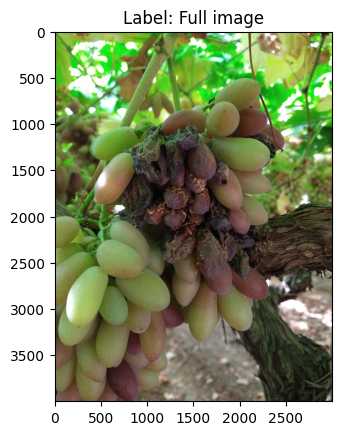

(3000, 4000, 3)
Model loaded from checkpoint. Epoch 6
(9, 7)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


-1

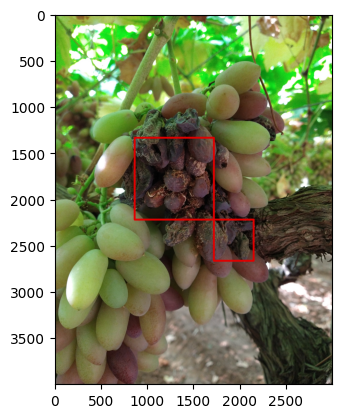

In [ ]:
image_path = os.path.join(DATA_DIR, "sickness/IMG_20210924_131131409.jpg")
original_image = np.array(Image.open(image_path).convert("RGB"))

plt.imshow(original_image.transpose(1,0,2))
plt.title(f"Label: Full image")
plt.show()
print(original_image.shape)
transform1 = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((original_image.shape[0]//7, original_image.shape[1]//7), antialias=True)         ,
            torchvision.transforms.Normalize(mean=[0.4021, 0.3569, 0.2781], std =[0.1811, 0.1833, 0.1774]),
        ]
    )

image = transform1(original_image)

#model = FCNBinaryResNet(pretrained=False)
model = FCNBinaryClassifier(num_classes=1)
model = model.to(DEVICE)

checkpoint = torch.load(os.path.join("drive/MyDrive/models/mia/background", f"Adam lr={1e-5} bs={128} -best"))

# Load the saved state dictionaries
model.load_state_dict(checkpoint['model_state_dict'])
epochs_so_far = checkpoint['epoch']

print("Model loaded from checkpoint. Epoch {}".format(epochs_so_far))

image = torch.unsqueeze(image,0).to(device=DEVICE)
score_map = model(image)
score_map = (score_map>0.8).int()
score_map = score_map.squeeze().cpu().detach().numpy()

print(score_map.transpose().shape)
print(score_map.transpose())

score_map = np.array(score_map, dtype=np.uint8)

#original_image = cv2.imread(image_path)
plt.imshow(original_image)
#plt.show

# Resize score map to the original image size
score_map = cv2.resize(score_map, (original_image.shape[1], original_image.shape[0]))

# Find the countour of the binary blob
contours, _ = cv2.findContours(score_map, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

# Find bounding box around the object.
for i in range(len(contours)):
  rect = cv2.boundingRect(contours[i])
  cv2.rectangle(original_image, rect[:2], (rect[0] + rect[2], rect[1] + rect[3]), (225,0, 0), 20)


#masked_image = (original_image * score_map).astype(np.uint8)

# Display bounding box
# Display images
plt.imshow(original_image.transpose(1,0,2))
plt.show

cv2.waitKey(0)

The results have seen an improvement but an even more reliable solution would be to make the classifier able to recognize not two classes but three: sick, healty and background but it would take us away from the objective of this research project which was to implement a fully convolutional binary classifier.

#Comparison with autoencoder
**The comparison is made with respect to the "Canopies Anomaly Detection" colab authored by Danny Antonelli and uploaded by the professor

The results obtained here are slightly better than those obtained with the Autoencoder (accuracy 91.5 vs 84.3). However this doesn't mean that the FCN model is always preferrable to the autoencoder for this tasks. The fundamental difference is that the autoencoder only trains on healty grapes and never sees a sick one. This allows the model to acquire the capacity to reconstruct healty images well and everything that deviates from what it's learned is recognized as an anomaly.
The FCN Classifier insted learns the features of both healty grapes and sick grapes and by doing this it learns to classify both. However in order to recognize an anomaly it has to see some kind of pattern that it's already learned. For this reason the FCN model might be better at detecting the kinds of sicknesses it's been trained for but it's limited by the amount of sick data that can be collected. The autoencoder instead might not be as precise but it can detect all kinds of anomalies that make the grapes look different from healty ones.